In [79]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import xarray as xr
import geopandas as gpd

## Climate data download

I have data on all states in India. The data can be found on the website copernicus.eu

The data correspond to : the soil temperature (level 1) : stl1, the volumetric soil water (layer 1) : swvl1, the surface net solar radiation : ssr, the evaporation from bare soil : evabs, the total precipitation and leaf area indices (high and low vegetation) : lai_hv and lai_lv.

I test first on Andhra Pradesh.

In [80]:
ds_Andhra_Pradesh = xr.open_dataset('../../Data/ClimateData/Andhra_Pradesh.nc')
df_Andhra_Pradesh = ds_Andhra_Pradesh.to_dataframe()
df_Andhra_Pradesh.reset_index(inplace=True)
df_Andhra_Pradesh = df_Andhra_Pradesh.drop(columns = ['time','longitude', 'latitude'])
print(df_Andhra_Pradesh)
cols = df_Andhra_Pradesh.columns.to_numpy()
mean_arr = df_Andhra_Pradesh.mean().to_numpy().reshape(1,7)
var_arr = df_Andhra_Pradesh.var().to_numpy().reshape(1,7)
print(mean_arr)

          evabs    lai_hv    lai_lv        stl1         ssr        tp  \
0     -0.001082  0.136969  1.169441  299.476501  15270657.0  0.000018   
1     -0.000896  0.135779  1.057388  301.407318  17259840.0  0.000225   
2     -0.001109  0.134406  0.999612  304.413452  18972736.0  0.000646   
3     -0.000801  0.134131  0.992789  309.339478  20230490.0  0.000451   
4     -0.001368  0.134131  0.992789  308.397644  19548000.0  0.001644   
...         ...       ...       ...         ...         ...       ...   
75271       NaN       NaN       NaN         NaN         NaN       NaN   
75272       NaN       NaN       NaN         NaN         NaN       NaN   
75273       NaN       NaN       NaN         NaN         NaN       NaN   
75274       NaN       NaN       NaN         NaN         NaN       NaN   
75275       NaN       NaN       NaN         NaN         NaN       NaN   

          swvl1  
0      0.246503  
1      0.247759  
2      0.289506  
3      0.257599  
4      0.291592  
...         ...

In [81]:
#mean_df = pd.DataFrame(mean_arr, columns = cols)
#mean_df

Now I work on all the states

In [82]:
states_names = ['Andhra_Pradesh', 'Bihar', 'Chhattisgarh', 'Gujarat', 'Haryana', 'Jharkhand', 'Karnataka', 'Madhya', 'Maharashtra', 'Odisha', 'Rajasthan', 'Tamil_Nadu', 'Telangana','Uttar_Pradesh', 'Uttarakhand', 'West_Bengal']

for state in states_names :
    if state != 'Andhra_Pradesh' :
        ds_state = xr.open_dataset(f'../../Data/ClimateData/{state}.nc')
        df_state = ds_state.to_dataframe()
        df_state.reset_index(inplace=True)
        df_state = df_state.drop(columns = ['time','longitude', 'latitude'])

        mean_arr = np.concatenate((mean_arr, df_state.mean().to_numpy().reshape(1,7)), axis=0)
        var_arr = np.concatenate((var_arr, df_state.var().to_numpy().reshape(1,7)), axis=0)

tot_arr = np.concatenate((mean_arr, var_arr), axis=1)
tot_df = pd.DataFrame(tot_arr) #,columns=cols
tot_df

,0,1,2,3,4,5,6,7,8,9,10,11,12,13
0,-0.001419,1.253139,1.406090,302.147705,15518060.0,0.002203,0.248794,5.338525e-07,1.529292,0.247044,12.549307,7.290430e+12,0.000007,0.008621
1,-0.001655,0.840681,1.462966,299.819580,14511972.0,0.003445,0.250221,3.971134e-07,1.028615,0.178592,27.700199,9.216851e+12,0.000019,0.009652
2,-0.001533,2.058173,2.143503,299.476166,15085622.0,0.003987,0.251370,2.785529e-07,0.252755,0.668467,19.526674,1.040617e+13,0.000028,0.011287
3,-0.000821,1.273033,1.304514,302.339966,15685694.0,0.001621,0.182341,6.048231e-07,0.957743,0.574634,20.567253,1.194506e+13,0.000010,0.014067
4,-0.000980,0.029176,1.110729,300.126190,14900950.0,0.001492,0.162914,7.522945e-07,0.054459,0.195496,51.553780,9.359153e+12,0.000004,0.006768
5,-0.001668,1.967572,2.050625,299.015442,14748817.0,0.003530,0.252371,2.815149e-07,0.269407,0.302272,23.239159,8.629671e+12,0.000021,0.010266
6,-0.001335,1.848203,1.625398,300.045624,15659798.0,0.003365,0.297114,5.313518e-07,2.125527,0.695320,11.655897,9.566126e+12,0.000028,0.013707
7,-0.001456,1.796592,1.862362,300.062195,15412315.0,0.002993,0.279778,4.320148e-07,0.438040,0.360855,29.171837,1.266442e+13,0.000022,0.009498
8,-0.001219,1.587225,1.741591,301.311310,15952608.0,0.002694,0.268606,5.570927e-07,0.664915,0.528829,16.162910,1.108542e+13,0.000019,0.011810
9,-0.001652,2.117540,2.340446,300.166992,14875499.0,0.004047,0.252900,2.469388e-07,0.307350,0.276432,16.892124,9.566067e+12,0.000025,0.011583


In [83]:
tot_df.insert(0,'state',states_names)

We obtain our dataframe. We are going to outline clusters between states based on this dataframe.

In [84]:
tot_df

,state,0,1,2,3,4,5,6,7,8,9,10,11,12,13
0,Andhra_Pradesh,-0.001419,1.253139,1.406090,302.147705,15518060.0,0.002203,0.248794,5.338525e-07,1.529292,0.247044,12.549307,7.290430e+12,0.000007,0.008621
1,Bihar,-0.001655,0.840681,1.462966,299.819580,14511972.0,0.003445,0.250221,3.971134e-07,1.028615,0.178592,27.700199,9.216851e+12,0.000019,0.009652
2,Chhattisgarh,-0.001533,2.058173,2.143503,299.476166,15085622.0,0.003987,0.251370,2.785529e-07,0.252755,0.668467,19.526674,1.040617e+13,0.000028,0.011287
3,Gujarat,-0.000821,1.273033,1.304514,302.339966,15685694.0,0.001621,0.182341,6.048231e-07,0.957743,0.574634,20.567253,1.194506e+13,0.000010,0.014067
4,Haryana,-0.000980,0.029176,1.110729,300.126190,14900950.0,0.001492,0.162914,7.522945e-07,0.054459,0.195496,51.553780,9.359153e+12,0.000004,0.006768
5,Jharkhand,-0.001668,1.967572,2.050625,299.015442,14748817.0,0.003530,0.252371,2.815149e-07,0.269407,0.302272,23.239159,8.629671e+12,0.000021,0.010266
6,Karnataka,-0.001335,1.848203,1.625398,300.045624,15659798.0,0.003365,0.297114,5.313518e-07,2.125527,0.695320,11.655897,9.566126e+12,0.000028,0.013707
7,Madhya,-0.001456,1.796592,1.862362,300.062195,15412315.0,0.002993,0.279778,4.320148e-07,0.438040,0.360855,29.171837,1.266442e+13,0.000022,0.009498
8,Maharashtra,-0.001219,1.587225,1.741591,301.311310,15952608.0,0.002694,0.268606,5.570927e-07,0.664915,0.528829,16.162910,1.108542e+13,0.000019,0.011810
9,Odisha,-0.001652,2.117540,2.340446,300.166992,14875499.0,0.004047,0.252900,2.469388e-07,0.307350,0.276432,16.892124,9.566067e+12,0.000025,0.011583


## K-means clustering

In [85]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import PowerTransformer
full_data=tot_df.drop(columns = ['state'])
full_data

,0,1,2,3,4,5,6,7,8,9,10,11,12,13
0,-0.001419,1.253139,1.406090,302.147705,15518060.0,0.002203,0.248794,5.338525e-07,1.529292,0.247044,12.549307,7.290430e+12,0.000007,0.008621
1,-0.001655,0.840681,1.462966,299.819580,14511972.0,0.003445,0.250221,3.971134e-07,1.028615,0.178592,27.700199,9.216851e+12,0.000019,0.009652
2,-0.001533,2.058173,2.143503,299.476166,15085622.0,0.003987,0.251370,2.785529e-07,0.252755,0.668467,19.526674,1.040617e+13,0.000028,0.011287
3,-0.000821,1.273033,1.304514,302.339966,15685694.0,0.001621,0.182341,6.048231e-07,0.957743,0.574634,20.567253,1.194506e+13,0.000010,0.014067
4,-0.000980,0.029176,1.110729,300.126190,14900950.0,0.001492,0.162914,7.522945e-07,0.054459,0.195496,51.553780,9.359153e+12,0.000004,0.006768
5,-0.001668,1.967572,2.050625,299.015442,14748817.0,0.003530,0.252371,2.815149e-07,0.269407,0.302272,23.239159,8.629671e+12,0.000021,0.010266
6,-0.001335,1.848203,1.625398,300.045624,15659798.0,0.003365,0.297114,5.313518e-07,2.125527,0.695320,11.655897,9.566126e+12,0.000028,0.013707
7,-0.001456,1.796592,1.862362,300.062195,15412315.0,0.002993,0.279778,4.320148e-07,0.438040,0.360855,29.171837,1.266442e+13,0.000022,0.009498
8,-0.001219,1.587225,1.741591,301.311310,15952608.0,0.002694,0.268606,5.570927e-07,0.664915,0.528829,16.162910,1.108542e+13,0.000019,0.011810
9,-0.001652,2.117540,2.340446,300.166992,14875499.0,0.004047,0.252900,2.469388e-07,0.307350,0.276432,16.892124,9.566067e+12,0.000025,0.011583


In [86]:
for c in full_data.columns:
    pt = PowerTransformer()
    full_data.loc[:, c] = pt.fit_transform(np.array(full_data[c]).reshape(-1, 1))

full_data

/Users/adrien/opt/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:195: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/Users/adrien/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2995: RuntimeWarning: overflow encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/Users/adrien/opt/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:199: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims)
/Users/adrien/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2995: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/Users/adrien/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2995: RuntimeWarning: overflow encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/Users/adrien/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2

,0,1,2,3,4,5,6,7,8,9,10,11,12,13
0,0.117108,-0.546961,-0.723774,0.788341,0.0,-0.814169,-0.087036,0.100147,0.918584,-0.790850,0.0,0.0,-1.250432,-0.859873
1,-0.980164,-1.130480,-0.586933,-0.054332,0.0,0.554041,-0.052769,-0.748160,0.344660,-1.486872,0.0,0.0,0.246851,-0.281584
2,-0.357399,1.048903,1.276105,-0.174636,0.0,1.291451,-0.024862,-1.596467,-1.187409,1.330090,0.0,0.0,1.417040,0.566423
3,1.508751,-0.514938,-0.960857,0.860084,0.0,-1.326372,-1.294172,0.948455,0.245283,1.050729,0.0,0.0,-0.879610,1.836991
4,1.266209,-1.859061,-1.387078,0.053933,0.0,-1.430485,-1.532348,1.891018,-1.844138,-1.299160,0.0,0.0,-1.664984,-1.988879
5,-1.054598,0.837781,0.997453,-0.334455,0.0,0.663187,-0.000311,-1.596467,-1.139662,-0.336357,0.0,0.0,0.453252,0.046223
6,0.410700,0.572081,-0.180021,0.025406,0.0,0.452914,1.335696,0.100147,1.406173,1.398395,0.0,0.0,1.327832,1.683700
7,-0.026061,0.461551,0.456189,0.031269,0.0,0.008308,0.758408,0.100147,-0.705745,0.064448,0.0,0.0,0.645659,-0.365915
8,0.748591,0.039743,0.125642,0.480099,0.0,-0.321234,0.427982,0.948455,-0.233547,0.886830,0.0,0.0,0.260844,0.821256
9,-0.965344,1.191709,1.892267,0.068401,0.0,1.379177,0.012735,-1.596467,-1.034437,-0.538665,0.0,0.0,1.016482,0.711777


<function matplotlib.pyplot.show(*args, **kw)>

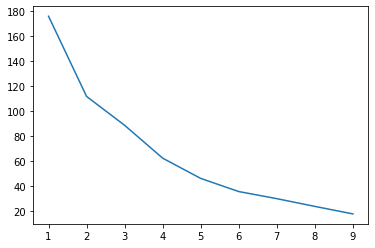

In [87]:
losses = []
X = [1,2,3,4,5,6,7,8,9]
for i in range(1,10) :
    kmeans = KMeans(n_clusters=i).fit(full_data)
    kmeans_loss = kmeans.inertia_
    losses.append(kmeans_loss)
plt.plot(X,losses)
plt.show

In [88]:
kmeans = KMeans(n_clusters=5).fit(full_data)
kmeans_labels = kmeans.labels_
print(kmeans_labels)

[0 0 3 1 2 3 1 1 1 3 2 0 1 0 4 3]


In [89]:
tot_df.insert(1,'cluster',kmeans_labels)
tot_df

,state,cluster,0,1,2,3,4,5,6,7,8,9,10,11,12,13
0,Andhra_Pradesh,0,-0.001419,1.253139,1.406090,302.147705,15518060.0,0.002203,0.248794,5.338525e-07,1.529292,0.247044,12.549307,7.290430e+12,0.000007,0.008621
1,Bihar,0,-0.001655,0.840681,1.462966,299.819580,14511972.0,0.003445,0.250221,3.971134e-07,1.028615,0.178592,27.700199,9.216851e+12,0.000019,0.009652
2,Chhattisgarh,3,-0.001533,2.058173,2.143503,299.476166,15085622.0,0.003987,0.251370,2.785529e-07,0.252755,0.668467,19.526674,1.040617e+13,0.000028,0.011287
3,Gujarat,1,-0.000821,1.273033,1.304514,302.339966,15685694.0,0.001621,0.182341,6.048231e-07,0.957743,0.574634,20.567253,1.194506e+13,0.000010,0.014067
4,Haryana,2,-0.000980,0.029176,1.110729,300.126190,14900950.0,0.001492,0.162914,7.522945e-07,0.054459,0.195496,51.553780,9.359153e+12,0.000004,0.006768
5,Jharkhand,3,-0.001668,1.967572,2.050625,299.015442,14748817.0,0.003530,0.252371,2.815149e-07,0.269407,0.302272,23.239159,8.629671e+12,0.000021,0.010266
6,Karnataka,1,-0.001335,1.848203,1.625398,300.045624,15659798.0,0.003365,0.297114,5.313518e-07,2.125527,0.695320,11.655897,9.566126e+12,0.000028,0.013707
7,Madhya,1,-0.001456,1.796592,1.862362,300.062195,15412315.0,0.002993,0.279778,4.320148e-07,0.438040,0.360855,29.171837,1.266442e+13,0.000022,0.009498
8,Maharashtra,1,-0.001219,1.587225,1.741591,301.311310,15952608.0,0.002694,0.268606,5.570927e-07,0.664915,0.528829,16.162910,1.108542e+13,0.000019,0.011810
9,Odisha,3,-0.001652,2.117540,2.340446,300.166992,14875499.0,0.004047,0.252900,2.469388e-07,0.307350,0.276432,16.892124,9.566067e+12,0.000025,0.011583


In [90]:
#plot_data=tot_df.drop(columns = ['evabs', 'lai_hv', 'lai_lv', 'stl1', 'ssr', 'tp', 'swvl1'])
plot_data=tot_df.copy()
plot_data['state'] = plot_data['state'].replace(to_replace='Andhra_Pradesh', value='Andhra Pradesh')
plot_data['state'] = plot_data['state'].replace(to_replace='Madhya', value='Madhya Pradesh')
plot_data['state'] = plot_data['state'].replace(to_replace='Tamil_Nadu', value='Tamil Nadu')
plot_data['state'] = plot_data['state'].replace(to_replace='Uttar_Pradesh', value='Uttar Pradesh')
plot_data['state'] = plot_data['state'].replace(to_replace='West_Bengal', value='West Bengal')
plot_data

,state,cluster,0,1,2,3,4,5,6,7,8,9,10,11,12,13
0,Andhra Pradesh,0,-0.001419,1.253139,1.406090,302.147705,15518060.0,0.002203,0.248794,5.338525e-07,1.529292,0.247044,12.549307,7.290430e+12,0.000007,0.008621
1,Bihar,0,-0.001655,0.840681,1.462966,299.819580,14511972.0,0.003445,0.250221,3.971134e-07,1.028615,0.178592,27.700199,9.216851e+12,0.000019,0.009652
2,Chhattisgarh,3,-0.001533,2.058173,2.143503,299.476166,15085622.0,0.003987,0.251370,2.785529e-07,0.252755,0.668467,19.526674,1.040617e+13,0.000028,0.011287
3,Gujarat,1,-0.000821,1.273033,1.304514,302.339966,15685694.0,0.001621,0.182341,6.048231e-07,0.957743,0.574634,20.567253,1.194506e+13,0.000010,0.014067
4,Haryana,2,-0.000980,0.029176,1.110729,300.126190,14900950.0,0.001492,0.162914,7.522945e-07,0.054459,0.195496,51.553780,9.359153e+12,0.000004,0.006768
5,Jharkhand,3,-0.001668,1.967572,2.050625,299.015442,14748817.0,0.003530,0.252371,2.815149e-07,0.269407,0.302272,23.239159,8.629671e+12,0.000021,0.010266
6,Karnataka,1,-0.001335,1.848203,1.625398,300.045624,15659798.0,0.003365,0.297114,5.313518e-07,2.125527,0.695320,11.655897,9.566126e+12,0.000028,0.013707
7,Madhya Pradesh,1,-0.001456,1.796592,1.862362,300.062195,15412315.0,0.002993,0.279778,4.320148e-07,0.438040,0.360855,29.171837,1.266442e+13,0.000022,0.009498
8,Maharashtra,1,-0.001219,1.587225,1.741591,301.311310,15952608.0,0.002694,0.268606,5.570927e-07,0.664915,0.528829,16.162910,1.108542e+13,0.000019,0.011810
9,Odisha,3,-0.001652,2.117540,2.340446,300.166992,14875499.0,0.004047,0.252900,2.469388e-07,0.307350,0.276432,16.892124,9.566067e+12,0.000025,0.011583


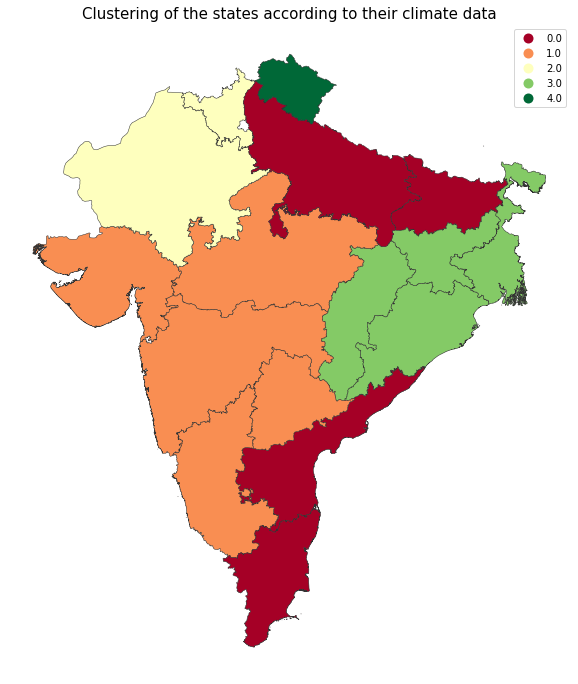

In [91]:
map_path = '../../maps/gadm36_IND_shp/gadm36_IND_1.shp'
map_gdf = gpd.read_file(map_path)
merged = map_gdf.set_index('NAME_1').join(plot_data.set_index('state'))

fig, ax = plt.subplots(1, figsize=(12, 12))
ax.axis('off')
ax.set_title('Clustering of the states according to their climate data',
            fontdict={'fontsize': '15', 'fontweight' : '3'})
fig = merged.plot(column='cluster', cmap='RdYlGn', linewidth=0.5, ax=ax, edgecolor='0.2', categorical=True, legend=True)

## Clustering according to the seasons

We split the dataset in two according to the season of the measures.

In [107]:
ds_Andhra_Pradesh = xr.open_dataset('../../Data/ClimateData/Andhra_Pradesh.nc')
df_Andhra_Pradesh = ds_Andhra_Pradesh.to_dataframe()
df_Andhra_Pradesh.reset_index(inplace=True)
df_Andhra_Pradesh = df_Andhra_Pradesh.drop(columns = ['longitude', 'latitude'])

time_arr = df_Andhra_Pradesh['time'].to_numpy()
#time_arr
months = time_arr.astype('datetime64[M]').astype(int) % 12 + 1
#months
months_df = pd.DataFrame(months, columns=['month']) 

kharif_months = [6,7,8,9,10]
rabi_months = [1,2,3,4,5,11,12]
df_Andhra_Pradesh['month'] = months_df['month']
df_AP_rabi = df_Andhra_Pradesh[df_Andhra_Pradesh['month'].isin(rabi_months)]
df_AP_kharif = df_Andhra_Pradesh[df_Andhra_Pradesh['month'].isin(kharif_months)]
df_AP_rabi = df_AP_rabi.drop(columns = ['time', 'month'])
df_AP_kharif = df_AP_kharif.drop(columns = ['time', 'month'])

cols = df_AP_rabi.columns.to_numpy()
#print(cols)

mean_rabi_arr = df_AP_rabi.mean().to_numpy().reshape(1,7)
mean_kharif_arr = df_AP_kharif.mean().to_numpy().reshape(1,7)
var_rabi_arr = df_AP_rabi.var().to_numpy().reshape(1,7)
var_kharif_arr = df_AP_kharif.var().to_numpy().reshape(1,7)
#print(mean_rabi_arr)
#print(mean_kharif_arr)

states_names = ['Andhra_Pradesh', 'Bihar', 'Chhattisgarh', 'Gujarat', 'Haryana', 'Jharkhand', 'Karnataka', 'Madhya', 'Maharashtra', 'Odisha', 'Rajasthan', 'Tamil_Nadu', 'Telangana','Uttar_Pradesh', 'Uttarakhand', 'West_Bengal']

for state in states_names :
    if state != 'Andhra_Pradesh' :
        ds_state = xr.open_dataset(f'../../Data/ClimateData/{state}.nc')
        df_state = ds_state.to_dataframe()
        df_state.reset_index(inplace=True)
        df_state = df_state.drop(columns = ['longitude', 'latitude'])

        time_arr = df_state['time'].to_numpy()
        months = time_arr.astype('datetime64[M]').astype(int) % 12 + 1
        months_df = pd.DataFrame(months, columns=['month']) 

        df_state['month'] = months_df['month']
        df_state_rabi = df_state[df_state['month'].isin(rabi_months)]
        df_state_kharif = df_state[df_state['month'].isin(kharif_months)]
        df_state_rabi = df_state_rabi.drop(columns = ['time', 'month'])
        df_state_kharif = df_state_kharif.drop(columns = ['time', 'month'])

        mean_rabi_arr = np.concatenate((mean_rabi_arr,df_state_rabi.mean().to_numpy().reshape(1,7)), axis=0)
        mean_kharif_arr = np.concatenate((mean_kharif_arr,df_state_kharif.mean().to_numpy().reshape(1,7)), axis=0)
        var_rabi_arr = np.concatenate((var_rabi_arr,df_state_rabi.var().to_numpy().reshape(1,7)), axis=0)
        var_kharif_arr = np.concatenate((var_kharif_arr,df_state_kharif.var().to_numpy().reshape(1,7)), axis=0)

tot_rabi_arr = np.concatenate((mean_rabi_arr, var_rabi_arr), axis=1)
tot_kharif_arr = np.concatenate((mean_kharif_arr, var_rabi_arr), axis=1)

tot_rabi_df = pd.DataFrame(tot_rabi_arr)
tot_kharif_df = pd.DataFrame(tot_kharif_arr)

tot_rabi_df.insert(0,'state',states_names)
tot_kharif_df.insert(0,'state',states_names)

#print(mean_rabi_df)
#print(mean_kharif_df)

### Rabi clustering

/Users/adrien/opt/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:195: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/Users/adrien/opt/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:199: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims)
/Users/adrien/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2995: RuntimeWarning: overflow encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/Users/adrien/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2995: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/Users/adrien/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2995: RuntimeWarning: overflow encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/Users/adrien/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2

<function matplotlib.pyplot.show(*args, **kw)>

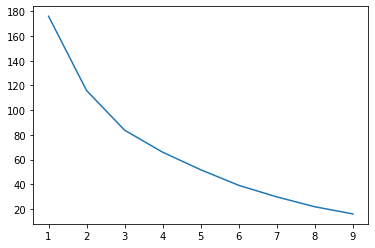

In [108]:
full_data=tot_rabi_df.drop(columns = ['state'])

for c in full_data.columns:
    pt = PowerTransformer()
    full_data.loc[:, c] = pt.fit_transform(np.array(full_data[c]).reshape(-1, 1))

losses = []
X = [1,2,3,4,5,6,7,8,9]
for i in range(1,10) :
    kmeans = KMeans(n_clusters=i).fit(full_data)
    kmeans_loss = kmeans.inertia_
    losses.append(kmeans_loss)
plt.plot(X,losses)
plt.show

In [109]:
kmeans = KMeans(n_clusters=5).fit(full_data)
kmeans_labels = kmeans.labels_
tot_rabi_df.insert(1,'cluster',kmeans_labels)
#plot_data=tot_rabi_df.drop(columns = ['evabs', 'lai_hv', 'lai_lv', 'stl1', 'ssr', 'tp', 'swvl1'])
plot_data = tot_rabi_df.copy()
plot_data['state'] = plot_data['state'].replace(to_replace='Andhra_Pradesh', value='Andhra Pradesh')
plot_data['state'] = plot_data['state'].replace(to_replace='Madhya', value='Madhya Pradesh')
plot_data['state'] = plot_data['state'].replace(to_replace='Tamil_Nadu', value='Tamil Nadu')
plot_data['state'] = plot_data['state'].replace(to_replace='Uttar_Pradesh', value='Uttar Pradesh')
plot_data['state'] = plot_data['state'].replace(to_replace='West_Bengal', value='West Bengal')
plot_data

,state,cluster,0,1,2,3,4,5,6,7,8,9,10,11,12,13
0,Andhra Pradesh,4,-0.001095,1.245288,1.357867,302.305847,16694056.0,0.001066,0.205877,3.470216e-07,1.516188,0.239620,17.468702,6.862033e+12,4.187995e-06,0.005884
1,Bihar,4,-0.001335,0.832904,1.383169,297.951965,15313947.0,0.000732,0.177892,1.841646e-07,1.008278,0.140978,35.147507,1.155660e+13,1.252010e-06,0.001080
2,Chhattisgarh,1,-0.001366,1.971766,2.086627,299.049744,16821118.0,0.000554,0.174314,1.701512e-07,0.240079,0.654541,28.259800,6.306505e+12,5.041430e-07,0.002188
3,Gujarat,0,-0.000580,1.254099,1.266260,301.509979,17056450.0,0.000076,0.134701,2.176755e-07,0.939295,0.543786,26.927801,1.013331e+13,2.915756e-08,0.007130
4,Haryana,0,-0.000639,0.029174,1.108085,296.559143,14723102.0,0.000721,0.139796,3.536449e-07,0.054455,0.227700,50.625259,1.335347e+13,7.771154e-07,0.004525
5,Jharkhand,1,-0.001469,1.913781,1.947228,297.765442,16041356.0,0.000760,0.178186,1.967832e-07,0.264889,0.321834,32.533905,7.924930e+12,7.418153e-07,0.001539
6,Karnataka,2,-0.001258,1.911460,1.610050,301.116760,17529332.0,0.001039,0.235098,4.672947e-07,2.375377,0.706406,14.407709,4.918071e+12,2.800967e-06,0.009087
7,Madhya Pradesh,1,-0.001209,1.748353,1.786221,298.892029,16750470.0,0.000542,0.227191,2.115461e-07,0.425097,0.355400,38.703114,1.078948e+13,4.999184e-07,0.004179
8,Maharashtra,1,-0.000998,1.545032,1.673638,301.841736,17782052.0,0.000454,0.207787,3.049590e-07,0.645200,0.509578,22.199940,6.771802e+12,3.293117e-07,0.005695
9,Odisha,1,-0.001509,2.042240,2.264657,299.810455,16567049.0,0.000763,0.172957,1.817913e-07,0.304657,0.283333,25.325974,6.295235e+12,1.213377e-06,0.002067


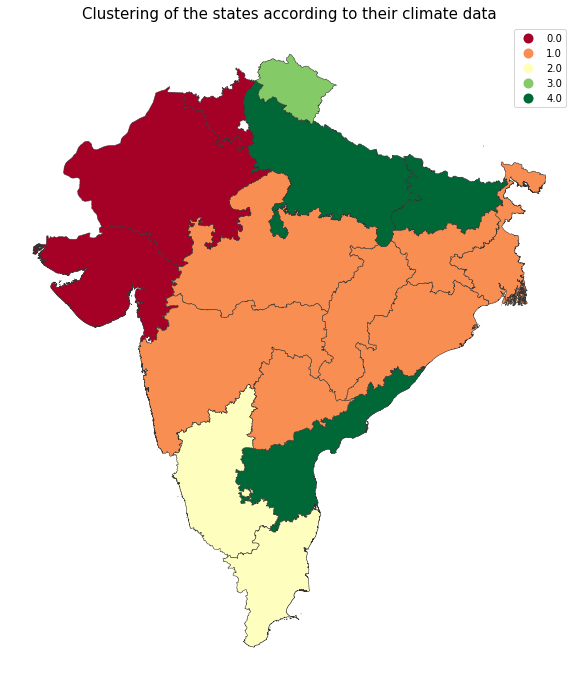

In [110]:
map_path = '../../maps/gadm36_IND_shp/gadm36_IND_1.shp'
map_gdf = gpd.read_file(map_path)
merged = map_gdf.set_index('NAME_1').join(plot_data.set_index('state'))

fig, ax = plt.subplots(1, figsize=(12, 12))
ax.axis('off')
ax.set_title('Clustering of the states according to their climate data',
            fontdict={'fontsize': '15', 'fontweight' : '3'})
fig = merged.plot(column='cluster', cmap='RdYlGn', linewidth=0.5, ax=ax, edgecolor='0.2', categorical=True, legend=True)

In [111]:
plot_data = plot_data.drop(columns=[0,1,2,3,4,5,6,7,8,9,10,11,12,13])
plot_data

,state,cluster
0,Andhra Pradesh,4
1,Bihar,4
2,Chhattisgarh,1
3,Gujarat,0
4,Haryana,0
5,Jharkhand,1
6,Karnataka,2
7,Madhya Pradesh,1
8,Maharashtra,1
9,Odisha,1


In [113]:
plot_data.to_csv('../../Outputs/Predictions/climate_clusters_rabi')

### Kharif clustering

/Users/adrien/opt/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:195: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/Users/adrien/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2995: RuntimeWarning: overflow encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/Users/adrien/opt/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:199: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims)
/Users/adrien/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2995: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/Users/adrien/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2995: RuntimeWarning: overflow encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/Users/adrien/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2

<function matplotlib.pyplot.show(*args, **kw)>

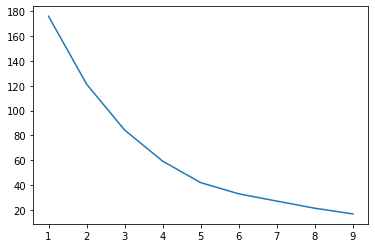

In [115]:
full_data=tot_kharif_df.drop(columns = ['state'])

for c in full_data.columns:
    pt = PowerTransformer()
    full_data.loc[:, c] = pt.fit_transform(np.array(full_data[c]).reshape(-1, 1))

losses = []
X = [1,2,3,4,5,6,7,8,9]
for i in range(1,10) :
    kmeans = KMeans(n_clusters=i).fit(full_data)
    kmeans_loss = kmeans.inertia_
    losses.append(kmeans_loss)
plt.plot(X,losses)
plt.show

In [116]:
kmeans = KMeans(n_clusters=5).fit(full_data)
kmeans_labels = kmeans.labels_
tot_kharif_df.insert(1,'cluster',kmeans_labels)
#plot_data=tot_kharif_df.drop(columns = ['evabs', 'lai_hv', 'lai_lv', 'stl1', 'ssr', 'tp', 'swvl1'])
plot_data=tot_kharif_df.copy()
plot_data['state'] = plot_data['state'].replace(to_replace='Andhra_Pradesh', value='Andhra Pradesh')
plot_data['state'] = plot_data['state'].replace(to_replace='Madhya', value='Madhya Pradesh')
plot_data['state'] = plot_data['state'].replace(to_replace='Tamil_Nadu', value='Tamil Nadu')
plot_data['state'] = plot_data['state'].replace(to_replace='Uttar_Pradesh', value='Uttar Pradesh')
plot_data['state'] = plot_data['state'].replace(to_replace='West_Bengal', value='West Bengal')
plot_data

,state,cluster,0,1,2,3,4,5,6,7,8,9,10,11,12,13
0,Andhra Pradesh,4,-0.001872,1.264157,1.473600,301.927917,13871561.0,0.003793,0.308878,3.470216e-07,1.516188,0.239620,17.468702,6.862033e+12,4.187995e-06,0.005884
1,Bihar,4,-0.002103,0.851579,1.574675,302.434204,13389140.0,0.007244,0.351481,1.841646e-07,1.008278,0.140978,35.147507,1.155660e+13,1.252010e-06,0.001080
2,Chhattisgarh,1,-0.001767,2.179172,2.223156,300.076141,12656135.0,0.008792,0.359247,1.701512e-07,0.240079,0.654541,28.259800,6.306505e+12,5.041430e-07,0.002188
3,Gujarat,0,-0.001160,1.299586,1.358056,303.502991,13766843.0,0.003785,0.249037,2.176755e-07,0.939295,0.543786,26.927801,1.013331e+13,2.915756e-08,0.007130
4,Haryana,0,-0.001458,0.029178,1.114460,305.119232,15150073.0,0.002573,0.195282,3.536449e-07,0.054455,0.227700,50.625259,1.335347e+13,7.771154e-07,0.004525
5,Jharkhand,1,-0.001947,2.042865,2.195355,300.758484,12939235.0,0.007408,0.356230,1.967832e-07,0.264889,0.321834,32.533905,7.924930e+12,7.418153e-07,0.001539
6,Karnataka,3,-0.001442,1.759571,1.646904,298.548523,13042459.0,0.006622,0.383934,4.672947e-07,2.375377,0.706406,14.407709,4.918071e+12,2.800967e-06,0.009087
7,Madhya Pradesh,1,-0.001801,1.864114,1.969031,301.698975,13539031.0,0.006425,0.353395,2.115461e-07,0.425097,0.355400,38.703114,1.078948e+13,4.999184e-07,0.004179
8,Maharashtra,1,-0.001530,1.646330,1.836743,300.578033,13391280.0,0.005830,0.353757,3.049590e-07,0.645200,0.509578,22.199940,6.771802e+12,3.293117e-07,0.005695
9,Odisha,1,-0.001854,2.222998,2.446573,300.667053,12507390.0,0.008644,0.364818,1.817913e-07,0.304657,0.283333,25.325974,6.295235e+12,1.213377e-06,0.002067


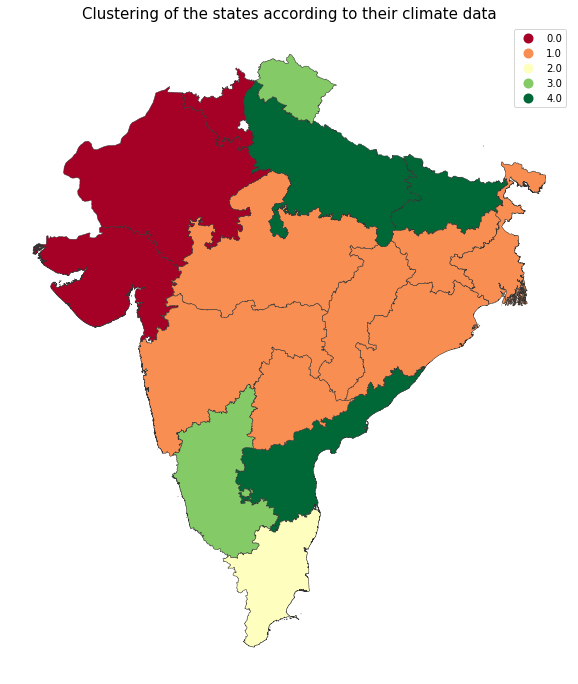

In [117]:
map_path = '../../maps/gadm36_IND_shp/gadm36_IND_1.shp'
map_gdf = gpd.read_file(map_path)
merged = map_gdf.set_index('NAME_1').join(plot_data.set_index('state'))

fig, ax = plt.subplots(1, figsize=(12, 12))
ax.axis('off')
ax.set_title('Clustering of the states according to their climate data',
            fontdict={'fontsize': '15', 'fontweight' : '3'})
fig = merged.plot(column='cluster', cmap='RdYlGn', linewidth=0.5, ax=ax, edgecolor='0.2', categorical=True, legend=True)

In [118]:
plot_data = plot_data.drop(columns=[0,1,2,3,4,5,6,7,8,9,10,11,12,13])
plot_data.to_csv('../../Outputs/Predictions/climate_clusters_kharif')